In [1]:
#HW3 Question1 HamidrezaMafi 610399209
from google.colab import files
print("Please upload your kaggle.json file")
files.upload()

# === 1. INSTALL DEPENDENCIES ===
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# === 2. DOWNLOAD DATASET FROM KAGGLE ===
!kaggle datasets download -d gpiosenka/sports-classification
!unzip -q sports-classification.zip -d sports_data

# === 3. IMPORT LIBRARIES ===
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import vgg19, VGG19_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np




Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
 79% 336M/424M [00:00<00:00, 1.19GB/s]
100% 424M/424M [00:00<00:00, 1.21GB/s]


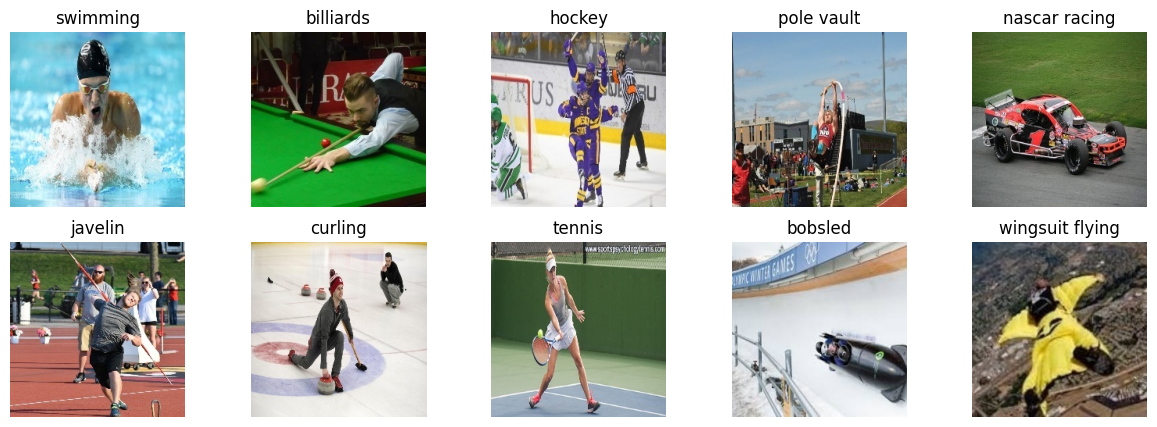

In [2]:
train_dir = '/content/sports_data/train'
test_dir= '/content/sports_data/test'
val_dir = '/content/sports_data/valid'


transform = transforms.Compose([
    transforms.ToTensor(),
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class_names = train_dataset.classes

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

data_iter = iter(train_loader)
images, labels = next(data_iter)
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    imshow(images[i], class_names[labels[i]])
plt.show()

In [3]:
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class SportVGG(nn.Module):
    def __init__(self):
        super(SportVGG, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.DEFAULT)
        self.features = vgg.features[:36]
        self.conv1x1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, bias=False)

        with torch.no_grad():
            self.conv1x1.weight.zero_()
            idx = torch.arange(256)
            self.conv1x1.weight[idx, 2 * idx, 0, 0] = 1
            self.conv1x1.weight[idx, 2 * idx + 1, 0, 0] = 1

        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 100),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.features(x)
        feature_maps = self.conv1x1(x)
        x = feature_maps.view(x.size(0), -1)
        x = self.classifier(x)
        return x, feature_maps

In [10]:
# ==============================
# STAGE 1: Train Only the Classifier
# ==============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SportVGG().to(device)
criterion = nn.CrossEntropyLoss()

# Freeze VGG backbone
for param in model.features.parameters():
    param.requires_grad = False
for param in model.conv1x1.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Optimizer for classifier + conv1x1 layer
optimizer_stage1 = torch.optim.Adam(
    list(model.classifier.parameters()) + list(model.conv1x1.parameters()),
    lr=0.0001,
    weight_decay=1e-4
)

num_epochs_stage1 = 25
for epoch in range(num_epochs_stage1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_stage1.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_stage1.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # ---- Validation Loop ----
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    print(f"Stage 1 - Epoch {epoch+1}/{num_epochs_stage1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Stage 1 - Epoch 1/25 | Train Acc: 16.30% | Val Acc: 27.00%
Stage 1 - Epoch 2/25 | Train Acc: 30.08% | Val Acc: 29.60%
Stage 1 - Epoch 3/25 | Train Acc: 33.16% | Val Acc: 33.80%
Stage 1 - Epoch 4/25 | Train Acc: 37.91% | Val Acc: 38.20%
Stage 1 - Epoch 5/25 | Train Acc: 41.97% | Val Acc: 40.60%
Stage 1 - Epoch 6/25 | Train Acc: 45.91% | Val Acc: 45.20%
Stage 1 - Epoch 7/25 | Train Acc: 51.62% | Val Acc: 49.20%
Stage 1 - Epoch 8/25 | Train Acc: 55.37% | Val Acc: 51.60%
Stage 1 - Epoch 9/25 | Train Acc: 57.86% | Val Acc: 54.40%
Stage 1 - Epoch 10/25 | Train Acc: 60.21% | Val Acc: 56.20%
Stage 1 - Epoch 11/25 | Train Acc: 62.86% | Val Acc: 57.60%
Stage 1 - Epoch 12/25 | Train Acc: 64.37% | Val Acc: 59.40%
Stage 1 - Epoch 13/25 | Train Acc: 66.82% | Val Acc: 61.80%
Stage 1 - Epoch 14/25 | Train Acc: 70.24% | Val Acc: 65.60%
Stage 1 - Epoch 15/25 | Train Acc: 72.45% | Val Acc: 66.20%
Stage 1 - Epoch 16/25 | Train Acc: 74.06% | Val Acc: 67.80%
Stage 1 - Epoch 17/25 | Train Acc: 75.84% | Val A

In [12]:
# ==============================
# STAGE 2: Fine-tune the Full Model
# ==============================

print("\n--- Starting Stage 2: Fine-tuning the full model ---")

# Unfreeze top VGG layers
for param in model.features[-10:].parameters():
    param.requires_grad = True

# Optimizer with small LR for sensitive fine-tuning
optimizer_stage2 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_stage2, T_max=15)

num_epochs_stage2 = 15
for epoch in range(num_epochs_stage2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_stage2.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_stage2.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    scheduler.step()

    # ---- Validation Loop ----
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    print(f"Stage 2 - Epoch {epoch+1}/{num_epochs_stage2} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


--- Starting Stage 2: Fine-tuning the full model ---
Stage 2 - Epoch 1/15 | Train Acc: 87.06% | Val Acc: 76.60%
Stage 2 - Epoch 2/15 | Train Acc: 87.82% | Val Acc: 78.40%
Stage 2 - Epoch 3/15 | Train Acc: 88.48% | Val Acc: 77.80%
Stage 2 - Epoch 4/15 | Train Acc: 89.01% | Val Acc: 79.20%
Stage 2 - Epoch 5/15 | Train Acc: 89.16% | Val Acc: 80.40%
Stage 2 - Epoch 6/15 | Train Acc: 89.98% | Val Acc: 80.40%
Stage 2 - Epoch 7/15 | Train Acc: 90.22% | Val Acc: 80.80%
Stage 2 - Epoch 8/15 | Train Acc: 90.36% | Val Acc: 79.80%
Stage 2 - Epoch 9/15 | Train Acc: 90.39% | Val Acc: 80.80%
Stage 2 - Epoch 10/15 | Train Acc: 90.51% | Val Acc: 81.60%
Stage 2 - Epoch 11/15 | Train Acc: 91.11% | Val Acc: 81.40%
Stage 2 - Epoch 12/15 | Train Acc: 91.48% | Val Acc: 82.20%
Stage 2 - Epoch 13/15 | Train Acc: 91.52% | Val Acc: 81.80%
Stage 2 - Epoch 14/15 | Train Acc: 91.59% | Val Acc: 82.00%
Stage 2 - Epoch 15/15 | Train Acc: 91.63% | Val Acc: 82.00%


In [13]:
# === TEST ACCURACY AFTER TRAINING ===
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"📊 Final Test Accuracy: {test_acc:.2f}%")

📊 Final Test Accuracy: 84.60%


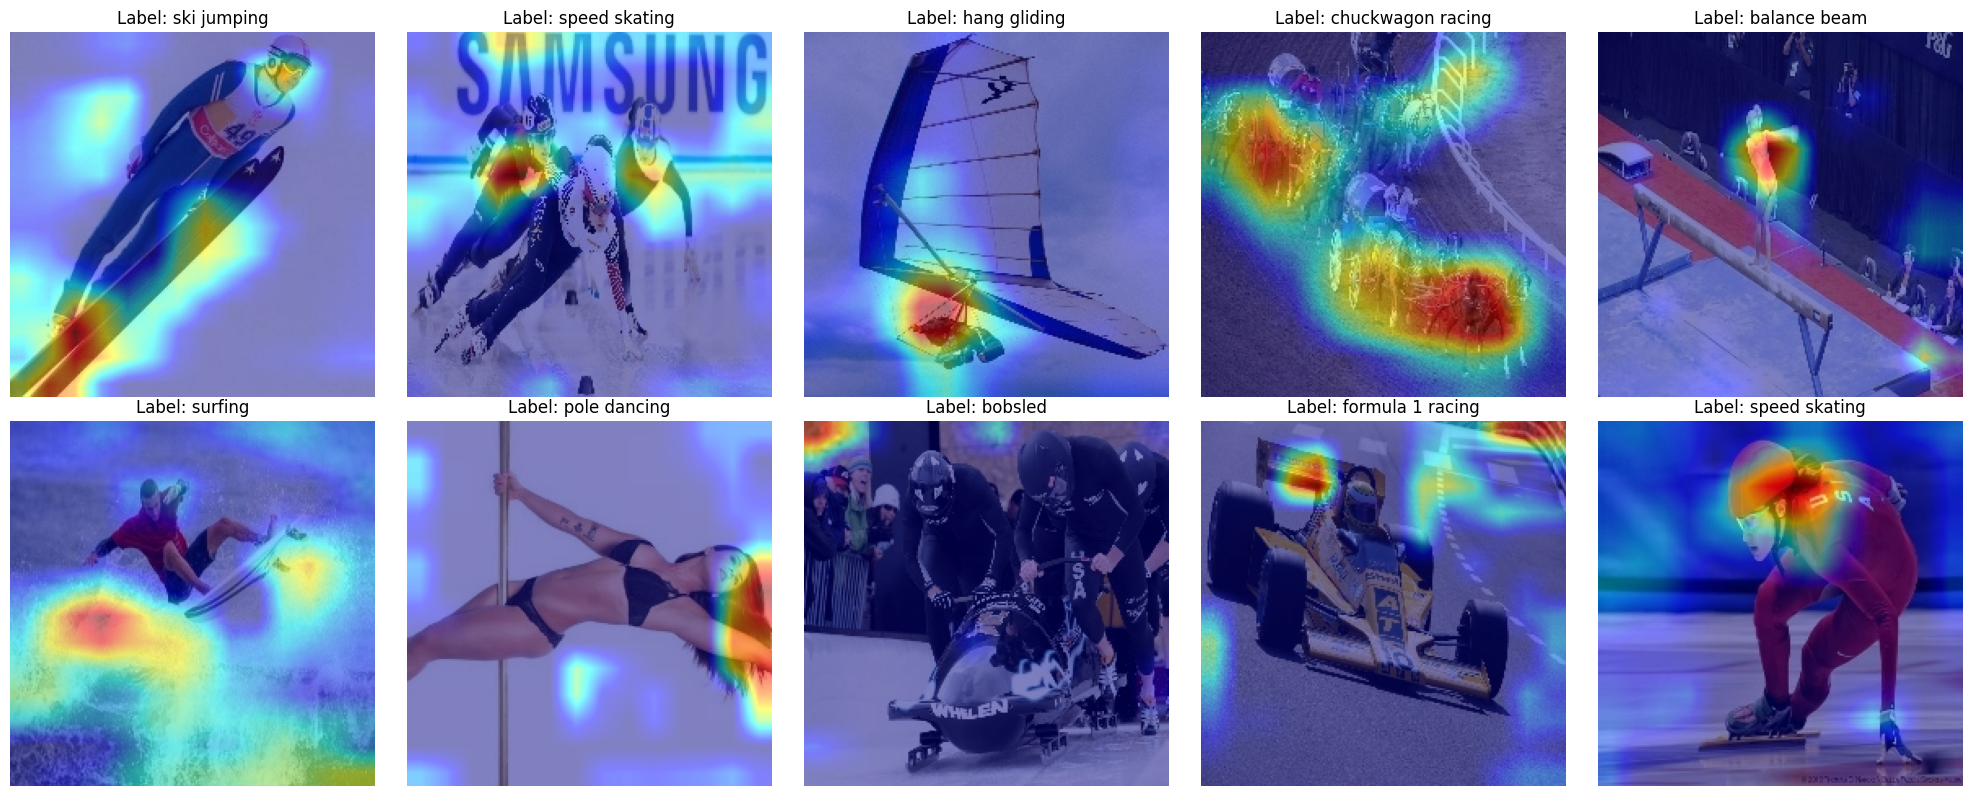

In [19]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output, _ = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)

        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()


def overlay_heatmap(img_tensor, cam, alpha=0.5):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img - img.min()
    img = img / img.max()
    img = np.uint8(255 * img)

    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    cam_inverted = 1 - cam_resized

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_inverted), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay


model.eval()
gradcam = GradCAM(model, target_layer=model.conv1x1)

samples = [val_dataset[i] for i in torch.randperm(len(val_dataset))[:10]]

plt.figure(figsize=(20, 8))
for idx, (img, label) in enumerate(samples):
    input_tensor = img.unsqueeze(0).to(device)
    cam = gradcam(input_tensor)
    overlay = overlay_heatmap(img, cam)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(overlay)
    plt.title(f'Label: {class_names[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
gradcam.remove_hooks()
